# Hands-on PyTorch

As all of you wanted a little bit more hands-on, I created a little puzzle game. For each cell, I provide you the commands, and you have/ can to use them. When you click on the words, you will be directed to the torch page, where you can find information on the modules and commands. Some keys have no link, because they are connected to objects of the torch library. You can look them up then on the corresponding pages. Have fun :)

In [43]:
!pip install braindecode

In [44]:
import torch 
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

## Dataset
Normally, we would write our own little data class - here we use the predefined MNIST for brevity. MNIST consists of a collection of handwritten digits from 0-9. This is the most classic example used in Deep Learning and is easily to access, since you can visualize the data and labels easily together.

Since I do not create a own dataset here, I paste a [link to a tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) on the PyTorch page where you can see how you work with the dataset class. You can also look into the "Deep Learning on EEG Data" colab notebook, to see how I did it (will be likely equal).

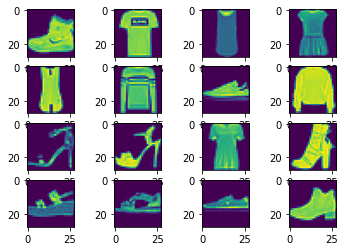

In [45]:
# Get training data and test data
training_data = FashionMNIST(root="data", train=True, download=True, transform=ToTensor(),)
test_data = FashionMNIST(root="data", train=False, download=True, transform=ToTensor(),)

# Plot the data (you can index into a dataset like a normal numpy array, tf.tensor ...)
fig, axs = plt.subplots(nrows=4, ncols=4)
for i in range(4):
  for j in range(4):
    axs[i, j].imshow(training_data[i*4 + j][0].squeeze(0))

plt.show()

## Model Creation

As you will do the classic image classification example yourself with torch, you can build a convolutional network as crazy as you want - it will score great. However, you can also try a fully connected network. This boils down to your experience and how much time you have. 

### Key Commands

[`torch.nn.Module()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), [`torch.nn.Softmax()`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax), [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), `def forward(self, x): ...`, [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)

Hint: Output size after convolution:
\begin{equation}
out = ⌊ \frac{input\_dim - kernel\_size}{stride} ⌋ + 1
\end{equation}




In [50]:
# Model
class MyModel(torch.nn.Module):
  def __init__(self, *unusedargs):
    super().__init__()

    # My models layers come here
    # --------------------------
    self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=8, stride=2, kernel_size=5)
    self.conv_2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.act = torch.nn.ReLU()
    self.max_pool = torch.nn.MaxPool2d(kernel_size=2)
    self.flatten = torch.nn.Flatten()
    self.out = torch.nn.Linear(in_features=400, out_features=10)
    self.softmax = torch.nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.conv_1(x)
    x = self.act(x)
    x = self.conv_2(x)
    x = self.act(x)
    x = self.max_pool(x)
    x = self.flatten(x)
    x = self.out(x)
    x = self.softmax(x)

    return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create the model 
my_model = MyModel()
print(my_model)

# Check if model is working
print(count_parameters(my_model))
for (x, y) in training_data:
  x = x[None, ...] # x.unsqueeze(0)
  print(x.shape)
  y_pred = my_model(x)
  print(y_pred)
  break



MyModel(
  (conv_1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (act): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=400, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)
5386
torch.Size([1, 1, 28, 28])
tensor([[0.1201, 0.1188, 0.0916, 0.0964, 0.0895, 0.0990, 0.0973, 0.0848, 0.0912,
         0.1114]], grad_fn=<SoftmaxBackward0>)


## Set up the Environment and Train

We will chose a loss function here, set up the optimizer and take care of the data loading process. Also, we will wrap everything into a training and a validation method (you can extend this for your project to this wrapper class style you saw in the tutorial). If you do this once, you are avoiding a lot of boilerplate code later on. 

### Key Commands 
[`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), [`torch.optim.scheduler`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()`, [`torch.utils.data.DataLoader()`](https://pytorch.org/docs/stable/data.html#multi-process-data-loading), `loss.item()`, `train_step(...)`, `val_step(...)`, [`torch.utils.data.random_split()`](https://pytorch.org/docs/stable/data.html#multi-process-data-loading)

If you want to use the gpu: `.to("cuda")`

In [51]:
def train_step(loader, model, optimizer, loss_fn):
  sum = 0
  #iterate
  for i, (x, y) in enumerate(loader):
    # Forward pass
    y_pred = model(x)

    # Measuring
    loss = loss_fn(y_pred, y)

    # Adjusting
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    sum += loss.item()

  return sum / (i+1)

def val_step(loader, model, loss_fn):
  sum = 0
  # iterate
  for i, (x, y) in enumerate(loader):
    # Forward pass
    y_pred = model(x)

    # Measuring
    loss = loss_fn(y_pred, y)

    sum += loss.item()

  return sum / (i+1)

# Setting the framework
learning_rate = 0.01
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.25, step_size=3)
loss_fn = torch.nn.CrossEntropyLoss()


# Wrap the dataset for easy loading
batch_size = 128
train_length = int(0.9 * len(training_data))
val_length = len(training_data) - train_length
train_set, val_set = torch.utils.data.random_split(training_data, lengths=[train_length, val_length])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)


# Train
n_epochs = 5
train_loss, val_loss = [], []
for epoch in range(n_epochs):
  print(f"Epoch {epoch}: ", end="")
  train_loss.append(train_step(train_loader, my_model, optimizer, loss_fn))
  val_loss.append(val_step(val_loader, my_model, loss_fn))

  print(f"Train Loss = {train_loss[-1]:>.6f}, Val. Loss = {val_loss[-1]:>.6f}, lr = {scheduler.get_last_lr()}")

  scheduler.step()



Epoch 0: Train Loss = 1.754530, Val. Loss = 1.723251, lr = [0.01]
Epoch 1: Train Loss = 1.715510, Val. Loss = 1.710673, lr = [0.01]
Epoch 2: Train Loss = 1.712450, Val. Loss = 1.703551, lr = [0.01]
Epoch 3: Train Loss = 1.701845, Val. Loss = 1.699420, lr = [0.0025]
Epoch 4: Train Loss = 1.700077, Val. Loss = 1.696955, lr = [0.0025]


## Evaluate on test set

We can evaluate on the test set, by simply predicting the labels and creating a confusion matrix. You can create a confusion matrix as in the tutorial on Deep Learning on EEG Data :). I already added pip install braindecode and imported sklearn.metrics.confusion_matrix and the plotting routine from braindecode.

You may want to use `with torch.no_grad():` around the for loop ;) 

In [ ]:
labels = test_data.targets
pred = []
with torch.no_grad():
  for (x, y) in test_data:
    y_pred = my_model(x[None, ...])
    pred.append(torch.argmax(y_pred))

conf_mat = confusion_matrix(y_true=labels, y_pred=pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plot_confusion_matrix(conf_mat, class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], figsize=(9, 9))
pass